# Analysis of Meps data

Data is provided by MET Norway through thredds.met.no. The spatial resolution is either 2.5 or 0.5 km which is regridded to 1 km using Fimex.

### Imports and setup

In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-notebook')
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

import sys, os
import datetime
import numpy as np
import netCDF4

import warnings
warnings.filterwarnings("ignore")

from aps.load_region import load_region, clip_region

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Numpy version: ', np.__version__)
print('Matplotlib version: ', matplotlib.__version__)
print('Today: ', datetime.date.today())

Python version: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]
Numpy version:  1.11.3
Matplotlib version:  2.0.2
Today:  2018-01-26


In [2]:
# Load region mask - only for data on 1km xgeo-grid
region_mask, y_min, y_max, x_min, x_max = load_region(3034)

### Cloud area fractions from meps_det_pp

Only variable "cloud_fraction" is contained in the default NVE extraction meps_det_pp...nc.

In [3]:
nc_kmu = netCDF4.Dataset(r"\\hdata\grid\tmp\kmu\meps\meps_det_pp_1km_2018012406.nc", "r")

time_v = nc_kmu.variables['time']

# Choose a time-step
t_index = 6
# Choose a pressure level (if applicable)
p_index = 12 # 12=1000hPa, 11=925hPa, 10=850hPa, ..., 7=500hPa, ..., 0=50hPa in arome_metcoop_test

ts = netCDF4.num2date(time_v[t_index], time_v.units)
print(ts)

2018-01-24 12:00:00


In [4]:
# clouds
cloud_cover = clip_region(nc_kmu.variables['cloud_area_fraction'], region_mask, t_index, y_min, y_max, x_min, x_max)
low_clouds = clip_region(nc_kmu.variables['low_type_cloud_area_fraction'], region_mask, t_index, y_min, y_max, x_min, x_max)
medium_clouds = clip_region(nc_kmu.variables['medium_type_cloud_area_fraction'], region_mask, t_index, y_min, y_max, x_min, x_max)
high_clouds = clip_region(nc_kmu.variables['high_type_cloud_area_fraction'], region_mask, t_index, y_min, y_max, x_min, x_max)

print(cloud_cover.shape, nc_kmu.variables['cloud_area_fraction'].shape)

(113, 106) (67, 1550, 1195)


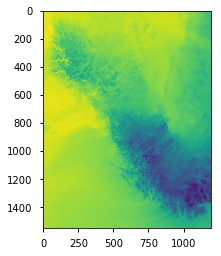

In [5]:
plt.imshow(nc_kmu.variables['air_temperature_2m'][t_index, 0,:,:])

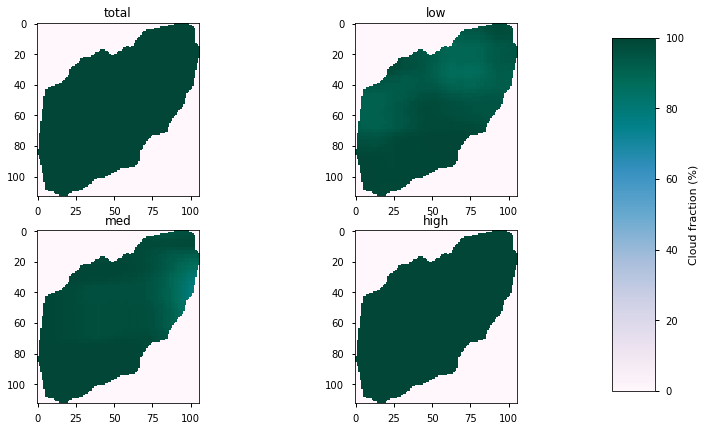

In [6]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

colormap = plt.cm.PuBuGn

for ax, data, tle in zip(axes.flat,
                         [cloud_cover, low_clouds, medium_clouds, high_clouds],
                         ["total", "low", "med", "high"]):
    im = ax.imshow(data, cmap=colormap, vmin=0, vmax=100)
    ax.set_title(tle)
    

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cb = f.colorbar(im, cax=cbar_ax)
cb.set_label('Cloud fraction (%)')

plt.show()

In [7]:
a = np.cumsum(cloud_cover)[-1] / cloud_cover.size
print("{0:.2f} cloud cover at {1}".format(a, ts))

61.07 cloud cover at 2018-01-24 12:00:00


## APS freezing level

In [8]:
air_temperature = clip_region(nc_kmu.variables['air_temperature_2m'], region_mask, t_index, y_min, y_max, x_min, x_max)
altitude = clip_region(nc_kmu.variables['altitude'], region_mask, t_index, y_min, y_max, x_min, x_max)

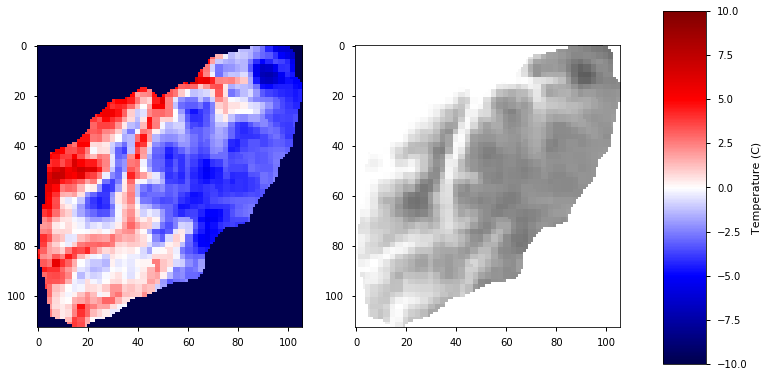

In [9]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,7))

im1 = ax1.imshow(air_temperature-273.15, cmap=plt.cm.seismic, vmin=-10, vmax=10)
im2 = ax2.imshow(altitude, cmap=plt.cm.Greys, vmin=0, vmax=2500)

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cb = f.colorbar(im1, cax=cbar_ax)
cb.set_label('Temperature (C)')

plt.show()

[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]] (113, 106) <class 'numpy.ma.core.MaskedArray'>


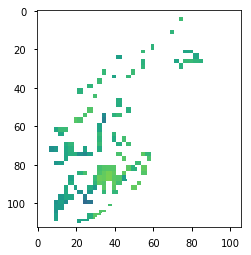

In [49]:
fl = altitude[air_temperature>272.65]
alt = np.ma.masked_where(air_temperature<272.65, altitude)
fl = np.ma.masked_where(air_temperature>273.65, alt)
print(fl, fl.shape, type(fl))

plt.imshow(fl, vmin=0, vmax=1500)

964.135480888
0 :  -66.2600021362
5 :  0.0
25 :  0.0
50 :  579.349975586
75 :  1193.75
95 :  1393.32995605
100 :  1765.4699707


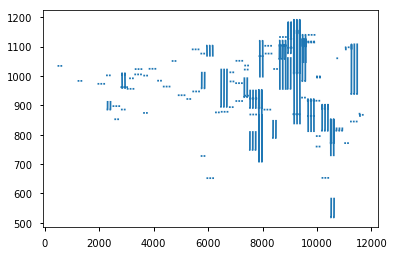

In [63]:
plt.plot(fl.flatten())
print(np.mean(fl.flatten()))
for p in [0,5,25,50,75,95,100]:
    print(p, ": ", np.percentile(fl.flatten(), p))

In [ ]:
nc_kmu.close()

In [64]:
nc_ex = netCDF4.Dataset(r"\\hdata\grid\tmp\kmu\meps\meps_det_extracted_1km_latest.nc", "r")

time_v_ex = nc_ex.variables['time']

# Choose a time-step
t_index = 6
# Choose a pressure level (if applicable)
p_index = 12 # 12=1000hPa, 11=925hPa, 10=850hPa, ..., 7=500hPa, ..., 0=50hPa in arome_metcoop_test

ts = netCDF4.num2date(time_v_ex[t_index], time_v_ex.units)
print(ts)

2018-01-25 12:00:00


In [82]:
isot = clip_region(nc_ex.variables['altitude_of_0_degree_isotherm'], region_mask, t_index, y_min, y_max, x_min, x_max)
print(np.median(isot),np.mean(isot),np.min(isot),np.max(isot), np.nanpercentile(isot, 95))

-- 408.793762504 0.0 1025.43 791.182556152


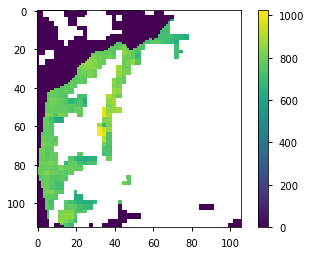

In [72]:
plt.imshow(isot)
plt.colorbar()

613.334 414.119 0.0 837.209 613.334228516 771.084228516


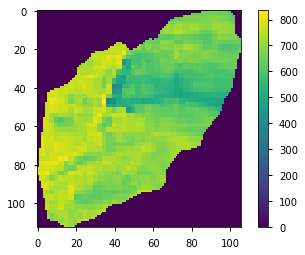

In [81]:
wetb = clip_region(nc_ex.variables['altitude_of_isoTprimW_equal_0'], region_mask, t_index, y_min, y_max, x_min, x_max)
print(np.median(wetb),np.mean(wetb),np.min(wetb),np.max(wetb), np.percentile(wetb, 50), np.nanpercentile(wetb, 95))
plt.imshow(wetb)
plt.colorbar()

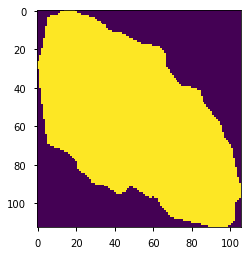

In [73]:
plt.imshow(region_mask)

In [ ]:
_vr = netCDF4.Dataset(r"../data/terrain_parameters/VarslingsOmr_2017.nc", "r")
_regions = _vr.variables["VarslingsOmr_2017"][:]

plt.imshow(_regions, vmin=3000, vmax=3050)